## Fitting

Model fitting to both spatial maps and spectra is one of the most common operations with spectral line data cubes, because it allows you to extract real physical information from interferometric data or a spectral cube.

I used the following link as a guide; https://radio-astro-tools.github.io/tutorials/fitting_with_spectralcube.html

#### SPECTRAL Fitting
Model how intensity varies with frequency or velocity. Essential for studying spectral line to obtain information about: 
- Central line velocity (→ gas movement).
- Line width (→ velocity dispersion, turbulence, thermal effects).
- Peak intensity (→ amount of emission, excitation temperature).
- Line profile (→ complex dynamics: multiple components, absorptions, outflows)


In [1]:
###### import the necessary libraries ######    
import warnings
import os
import numpy as np
import astropy.units as u   
import matplotlib.pyplot as plt

from spectral_cube import SpectralCube

#path of the data

file = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/cube_with_vel.fits' #path of the data
cube = SpectralCube.read(file, format = 'fits', use_dask = True) #read the data

print(cube) #print the data


DaskSpectralCube with shape=(2043, 128, 120) and unit=Jy / beam and chunk size (2043, 128, 120):
 n_x:    120  type_x: RA---SIN  unit_x: deg    range:    84.794668 deg:   85.014927 deg
 n_y:    128  type_y: DEC--SIN  unit_y: deg    range:   -69.807597 deg:  -69.726457 deg
 n_s:   2043  type_s: VRAD      unit_s: km / s  range:     -129.445 km / s:     599.071 km / s


In [2]:
#Statistics of the data
cube_stats =cube.statistics() #calculate the statistics of the data
print(cube_stats) #print the statistics of the data

{'npts': np.float64(14989491.0), 'min': <Quantity -0.1138537 Jy / beam>, 'max': <Quantity 0.11928345 Jy / beam>, 'sum': <Quantity -72.60558319 Jy / beam>, 'sumsq': <Quantity 2259.77270508 Jy2 / beam2>, 'mean': <Quantity -4.84376576e-06 Jy / beam>, 'sigma': <Quantity 0.01227832 Jy / beam>, 'rms': <Quantity 0.01227832 Jy / beam>}


We do extract a single spectrum with bright CO emission for this example. The pixel (y, x) = (63, 74) is a location of bright CF+ emission. 
We can extract one spectrum from the cube and plot it:

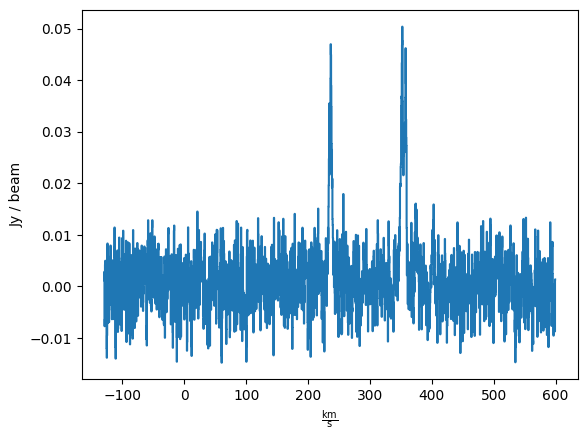

In [3]:
y = 74
x = 63 #coordinates of the pixel to be plotted


spec = cube[:, y, x] #extract the spectrum at the given pixel coordinates
spec.quicklook() #quicklook the spectrum

In [4]:
from astropy.modeling import models, fitting #import the models and fitting modules

# The 1D Gaussian model with initial guesses for parameters
gauss = models.Gaussian1D(amplitude=1.0 , mean=250, stddev=3.0) #create a Gaussian model
fit_g = fitting.LevMarLSQFitter() # And fit with the Levenberg-Marquardt algorithm and least squares statistic.

# The initial model, spectral axis (in km/s) and spectrum are passed for the fit
g_fit = fit_g(gauss, spec.spectral_axis, spec)
g_fit


<Gaussian1D(amplitude=0.03964152 Jy / beam, mean=236.32759737 km / s, stddev=2.28926586 km / s)>

Text(0.5, 0, 'Radio Velocity (km /s)')

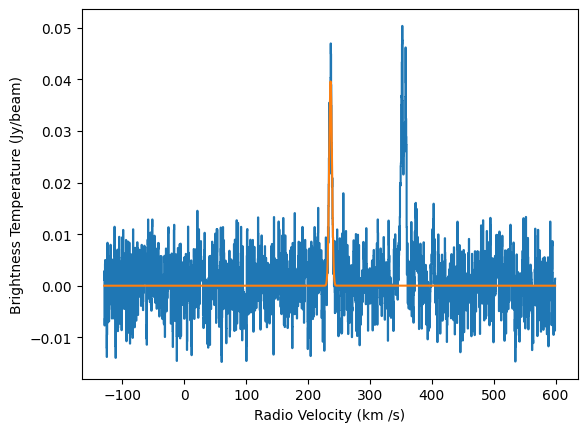

In [5]:
spec.quicklook()
plt.plot(spec.spectral_axis, g_fit(spec.spectral_axis))
plt.ylabel("Brightness Temperature (Jy/beam)")
plt.xlabel("Radio Velocity (km /s)")

#### Select velocities range

<Gaussian1D(amplitude=0.03964105 Jy / beam, mean=236.32756931 , stddev=2.28932041 )>

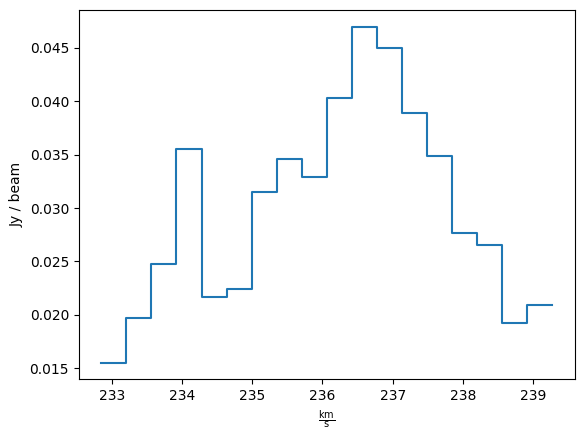

In [35]:
### Select the range of velocities corresponding to the signal
m_vel_cube = mask_cube.spectral_slab(220 * u.km / u.s, 250 * u.km / u.s) #select the range of velocities corresponding to the signal

specrange = m_vel_cube[:, y, x] #extract the spectrum at the given pixel coordinates
specrange.quicklook() #quicklook the spectrum

gauss_range = models.Gaussian1D(amplitude=np.max(specrange.value) , mean=250, stddev=5.0) #create a Gaussian model

g_fit2 = fit_g(gauss_range, specrange.spectral_axis.to_value(u.km / u.s), specrange)
g_fit2

Text(0.5, 0, 'Radio Velocity (km /s)')

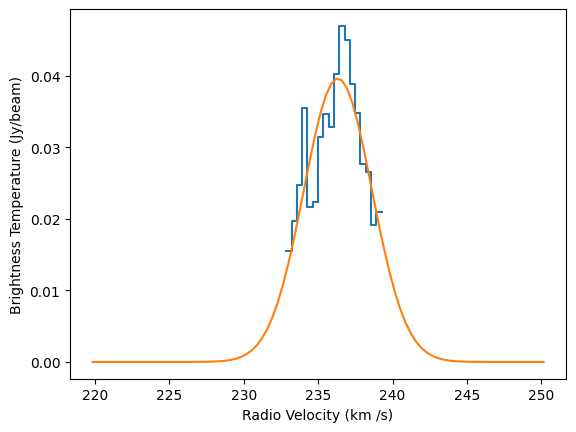

In [36]:
specrange.quicklook()
plt.plot(specrange.spectral_axis, g_fit2(specrange.spectral_axis.to_value(u.km / u.s)), label='Gaussian Fit')
plt.ylabel("Brightness Temperature (Jy/beam)")
plt.xlabel("Radio Velocity (km /s)")

#### Residual

Text(0.5, 0, 'Radio Velocity (km /s)')

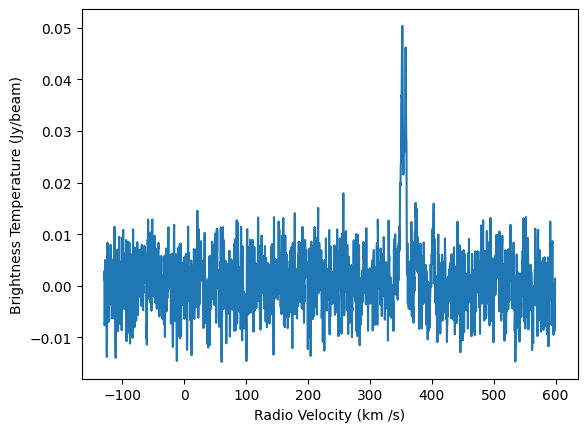

In [ ]:
# fit the residual
plt.plot(spec.spectral_axis, spec - g_fit(spec.spectral_axis))
plt.ylabel("Brightness Temperature (Jy/beam)")
plt.xlabel("Radio Velocity (km /s)")

Text(0.5, 0, 'Radio Velocity (km /s)')

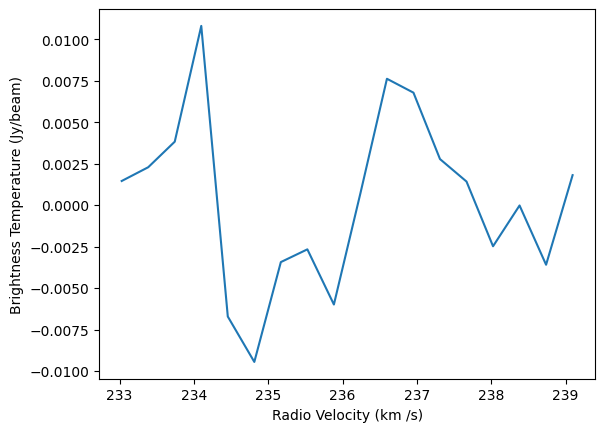

In [ ]:
# fit the residual (after the range selection)
plt.plot(specrange.spectral_axis.to_value(u.km / u.s), specrange - g_fit2(specrange.spectral_axis.to_value(u.km / u.s)))
plt.ylabel("Brightness Temperature (Jy/beam)")
plt.xlabel("Radio Velocity (km /s)")

### Spatial Fitting
modeling how the emission is distributed over the sky, channel by channel or over the integrated image. This is useful for:
- Angular size of the source 
- Shape (elongation, orientation, symmetry) 
- Exact position of the emission peak (fine astrometry) 
- Separation between multiple components (e.g. nuclei, jets, disks)

In this case, I will use a moment0 = integ. intensity

In [44]:
### Create a mask noisy values
mask_cube = cube.with_mask(cube > 0.01 *u.Jy / u.beam) #create a mask for the cube

m0 = m_vel_cube.moment(order=0) #calculate the zeroth moment of the cube

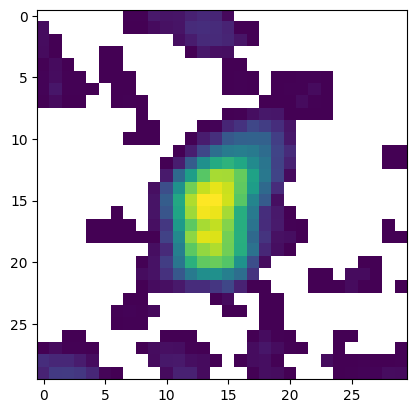

In [45]:
size = 15

m0_cut = m0[y-size:y+size, x-size:x+size] #cut the moment map to the size of the region of interest
m0_cut.quicklook(use_aplpy=True) #quicklook the moment map

In [46]:
# Define the spatial grid for the fit centered at y, x = 74, 64
yy, xx = m0_cut.spatial_coordinate_map

gauss2d = models.Gaussian2D(amplitude=1.0, x_mean=xx[size, size], y_mean=yy[size, size], x_stddev=3.0, y_stddev=3.0) #create a 2D Gaussian model
fit_g2d = fitting.LevMarLSQFitter() # And fit with the Levenberg-Marquardt algorithm and least squares statistic.


In [47]:
#set NaN values to zero for the fit
m0_cut_quant = m0_cut.quantity.value #convert the moment map to a numpy array
m0_cut_quant[np.isnan(m0_cut_quant)] = 0.0 #set NaN values to zero for the fit

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Ignore model linearity warning from the fitter
    g2d_fit = fit_g2d(gauss2d, xx, yy, m0_cut_quant) #fit the 2D Gaussian model to the moment map

g2d_fit

<Gaussian2D(amplitude=0.04352981 , x_mean=86.52207479 deg, y_mean=-68.24245217 deg, x_stddev=0. deg, y_stddev=0. deg, theta=0. rad)>

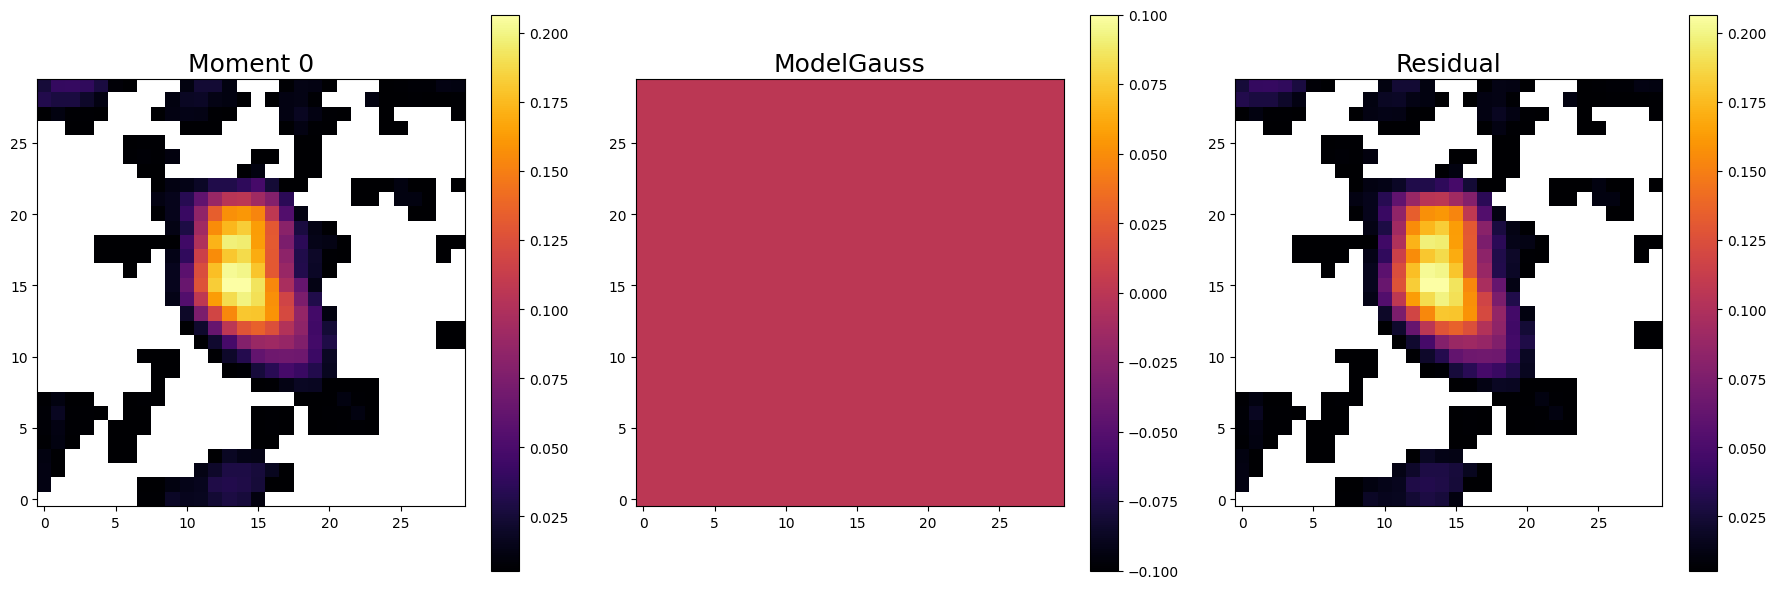

In [48]:
plt.figure(figsize=(18, 6))
g2d_model_with_unit = g2d_fit(xx, yy) * m0_cut.unit
residuals = (m0_cut - g2d_model_with_unit).value

plt.subplot(1, 3, 1)
plt.title("Moment 0", fontsize=18)
plt.imshow(m0_cut.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("ModelGauss", fontsize=18)
plt.imshow(g2d_model_with_unit.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Residual", fontsize=18)
plt.imshow(residuals, origin='lower', cmap='inferno')
plt.colorbar()

plt.tight_layout()